![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# Really simple GAN with Tensorflow

## Referencias




Simplificación de  

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

## Importaciones

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY



##Preparación de datos

In [4]:
# Datos
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


11490434/11490434 [==============================] - 0s 0us/step


In [6]:
X_train.max()

1.0

In [7]:
X_train.min()

-1.0

##Definición de la red

In [8]:
width=28
height=28
channels=1

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(learning_rate=0.0002, beta_1=0.5)

In [9]:
in_shape

(28, 28, 1)

In [10]:
# Generador

model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,)))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh'))
model_gen.add(Reshape(in_shape))
model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

In [11]:
# Discriminador

model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape=in_shape))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 108801 (425.00 KB)
Trainable params: 108

In [12]:
# modelo combinado

model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1493520   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 108801    
                                                                 
Total params: 1602321 (6.11 MB)
Trainable params: 1598737 (6.10 MB)
Non-trainable params: 3584 (14.00 KB)
_________________________________________________________________


## Entrenamiento

In [13]:

epochs = 5000
batch = 10

# Entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## train discriminator
    random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
    legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape((np.int64(batch/2),)+in_shape)

    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)

    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    # train generator

    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))

    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss




Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 25ms/step
epoch: 2500, [Discriminator :: d_loss: 0.872088], [ Generator :: loss: 0.301024]
1/1 [==============================] - 0s 29ms/step
epoch: 2501, [Discriminator :: d_loss: 0.802768], [ Generator :: loss: 0.293946]
1/1 [==============================] - 0s 38ms/step
epoch: 2502, [Discriminator :: d_loss: 0.860359], [ Generator :: loss: 0.299185]
1/1 [==============================] - 0s 54ms/step
epoch: 2503, [Discriminator :: d_loss: 0.829500], [ Generator :: loss: 0.288692]
1/1 [==============================] - 0s 37ms/step
epoch: 2504, [Discriminator :: d_loss: 0.861071], [ Generator :: loss: 0.306298]
1/1 [==============================] - 0s 30ms/step
epoch: 2505, [Discriminator :: d_loss: 0.828469], [ Generator :: loss: 0.299914]
1/1 [==============================] - 0s 35ms/step
epoch: 2506, [Discriminator :: d_loss: 0.838968], [ Generator :: loss: 0.297256]
1/1 [===

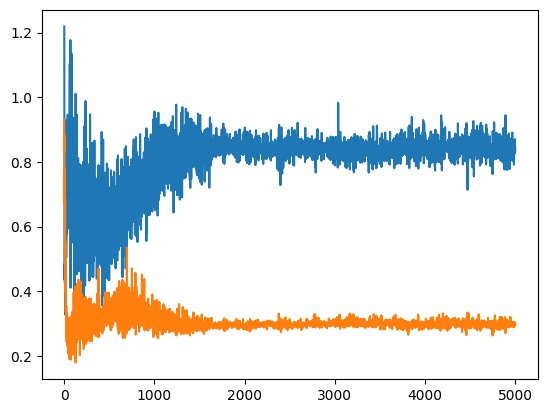

In [14]:
%matplotlib inline
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

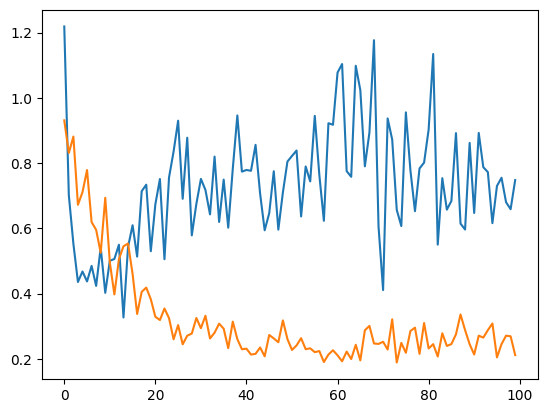

In [15]:

plt.figure
plt.plot(DD_loss[0:100])
plt.plot(GG_loss[0:100])

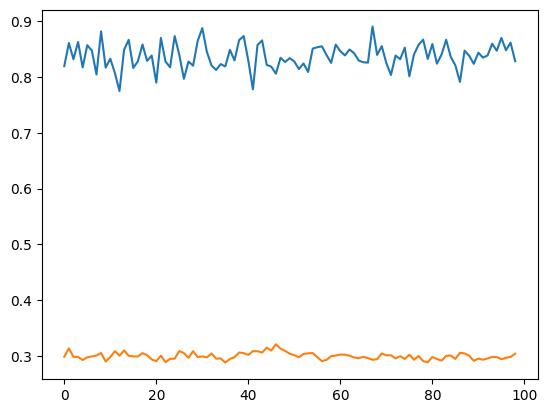

In [16]:

plt.figure
plt.plot(DD_loss[-100:-1])
plt.plot(GG_loss[-100:-1])

## Generación de datos

In [22]:
gen_noise = np.random.normal(0, 1, (np.int64(15), 100))
syntetic_images = model_gen.predict(gen_noise)

1/1 [==============================] - 0s 32ms/step


In [23]:
syntetic_images.shape

(15, 28, 28, 1)

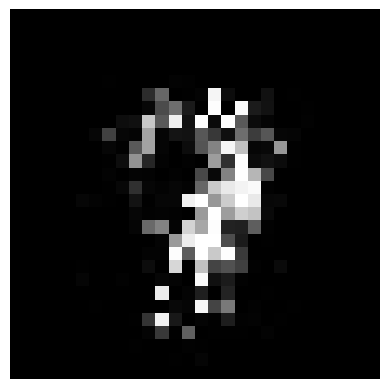

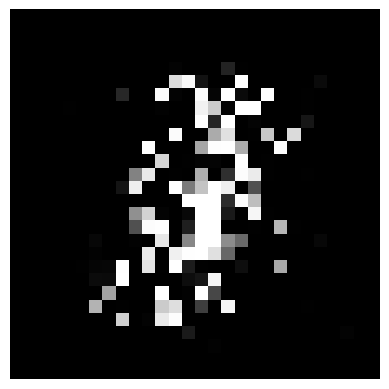

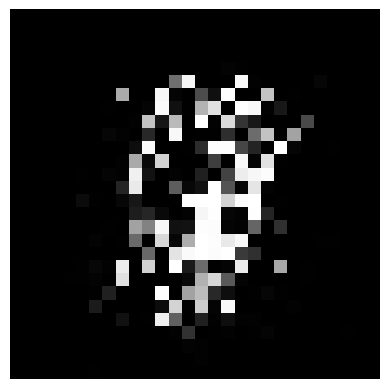

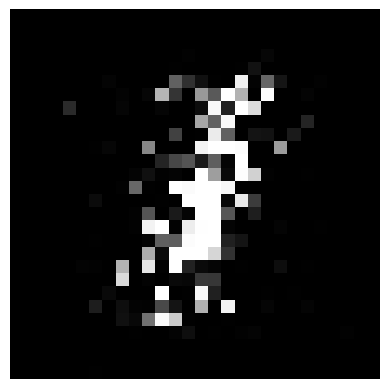

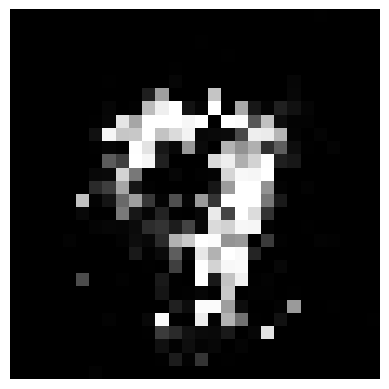

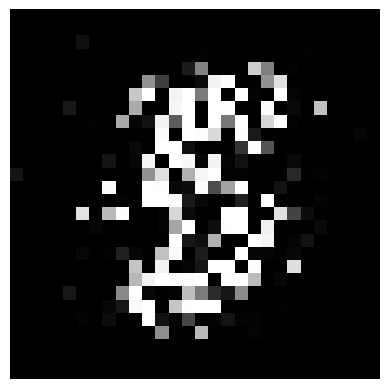

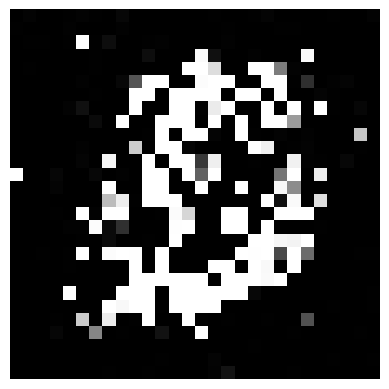

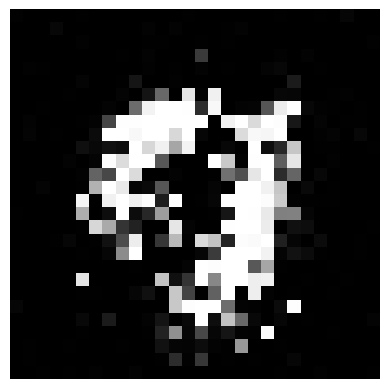

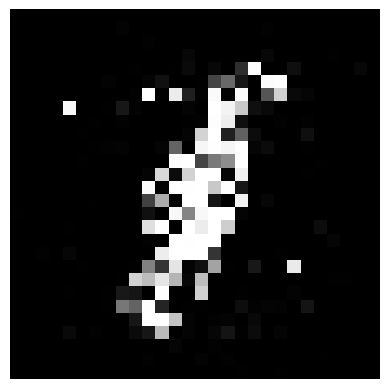

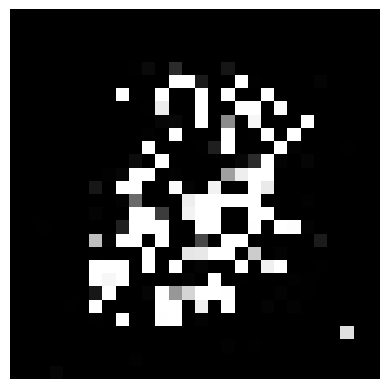

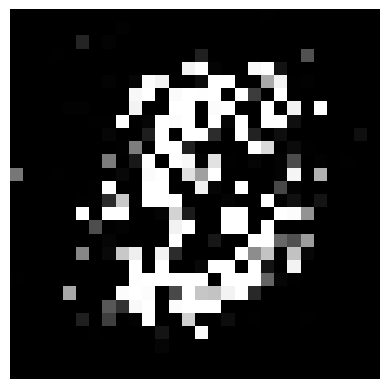

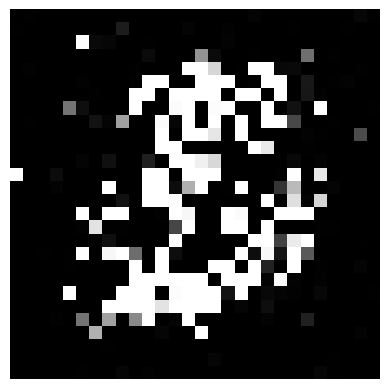

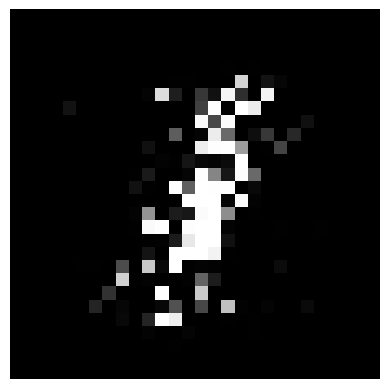

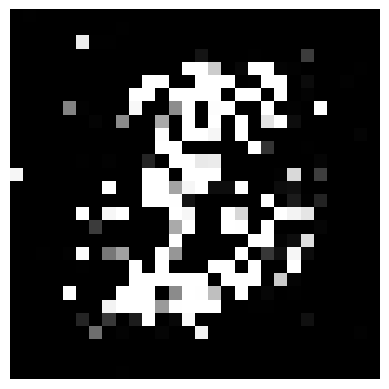

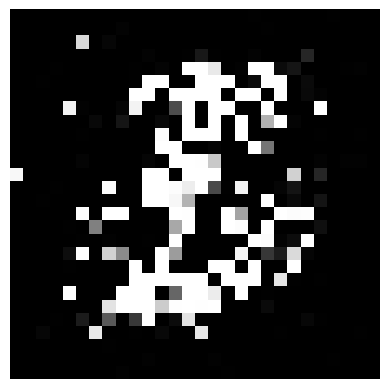

In [24]:
for ii in np.arange(0,15):
    plt.figure()
    plt.imshow(syntetic_images[ii,:,:,0],cmap='gray')
    plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

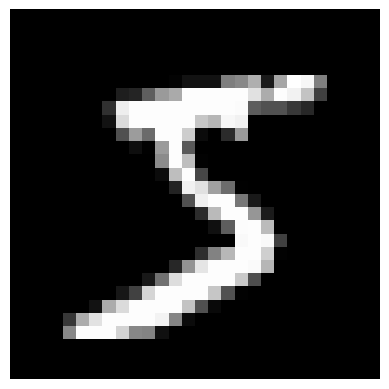

In [21]:
plt.imshow(X_train[0,:,:,0],cmap='gray')
plt.axis('off')